##Intro:
So at high level variational inference is easy: all we need to do is define a guide and compute gradients of the ELBO.

$ELBO ≡ E_{q_{\phi}(z)}[logp_{\theta}(x,z)−logq_{\phi}(z)]$. 

$logp_{\theta}(x)\geq ELBO$.

$logp_{\theta}(x)−ELBO=KL(q_{\phi}(z)‖p_{\theta}(z|x))$

In [1]:
from __future__ import print_function
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import matplotlib.pyplot as pyplot
import scipy.stats
import numpy as np
from tqdm import tqdm

data = []
for _ in range(100):
    data.append(torch.tensor(0.0))
for _ in range(400):
    data.append(torch.tensor(1.0))

In [131]:
def model(data):
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.0)
    ##sample from beta prior:
    f = pyro.sample('latent_fairness', dist.Beta(alpha0, beta0))
    #print(f)
    #loop over the observed data:
    for i in range(len(data)):
        #observe datapoints with bernoulli:
        pyro.sample('obs_{0}'.format(i), dist.Bernoulli(f), obs=data[i])

In [138]:
def guide(data):
    #Register two variational parameters with Pyro.
    alpha_q = pyro.param('alpha_q', torch.tensor(0.2), constraint = constraints.positive)
    beta_q = pyro.param('beta_q', torch.tensor(.01), constraint = constraints.positive)
    return pyro.sample('latent_fairness',dist.Normal(alpha_q, beta_q))

In [139]:
adam_params = {'lr':0.0005, 'betas':(0.9, 0.999)}
optimizer = Adam(adam_params)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
n_steps = 5000

# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
#n_steps = 2 if smoke_test else 2000

# enable validation (e.g. validate parameters of distributions)
pyro.enable_validation(True)

# clear the param store in case we're in a REPL
pyro.clear_param_store()
losses = []
for step in tqdm(range(n_steps)):
    losses.append(svi.step(data))
    if step % 100 == 0:
        print('.', end='')




  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 1/5000 [00:00<15:51,  5.25it/s]

  0%|          | 2/5000 [00:00<13:18,  6.26it/s]

.



  0%|          | 3/5000 [00:00<12:28,  6.67it/s]

  0%|          | 4/5000 [00:00<11:55,  6.98it/s]

  0%|          | 5/5000 [00:00<11:38,  7.15it/s]

  0%|          | 6/5000 [00:00<11:30,  7.24it/s]

  0%|          | 7/5000 [00:00<11:20,  7.33it/s]

  0%|          | 8/5000 [00:01<11:17,  7.37it/s]

  0%|          | 9/5000 [00:01<11:10,  7.45it/s]

  0%|          | 10/5000 [00:01<11:08,  7.47it/s]

  0%|          | 11/5000 [00:01<11:17,  7.36it/s]

  0%|          | 12/5000 [00:01<11:49,  7.03it/s]

  0%|          | 13/5000 [00:01<11:58,  6.94it/s]

  0%|          | 14/5000 [00:02<12:13,  6.79it/s]

  0%|          | 15/5000 [00:02<12:17,  6.76it/s]

  0%|          | 16/5000 [00:02<12:08,  6.84it/s]

  0%|          | 17/5000 [00:02<12:03,  6.89it/s]

  0%|          | 18/5000 [00:02<11:55,  6.96it/s]

  0%|          | 19/5000 [00:02<11:52,  6.99it/s]

  0%|          | 20/5000 [00:02<11:46,  7.05it/s]

  0%|          | 21/5000 [00:02<11:43,  7.08it/s]

  0%|          | 22/5000 [00:03<11:3

.



  2%|▏         | 103/5000 [00:12<09:42,  8.41it/s]

  2%|▏         | 104/5000 [00:12<09:41,  8.41it/s]

  2%|▏         | 105/5000 [00:12<09:41,  8.42it/s]

  2%|▏         | 106/5000 [00:12<09:41,  8.42it/s]

  2%|▏         | 107/5000 [00:12<09:40,  8.42it/s]

  2%|▏         | 108/5000 [00:12<09:40,  8.43it/s]

  2%|▏         | 109/5000 [00:12<09:40,  8.43it/s]

  2%|▏         | 110/5000 [00:13<09:39,  8.43it/s]

  2%|▏         | 111/5000 [00:13<09:39,  8.44it/s]

  2%|▏         | 112/5000 [00:13<09:38,  8.44it/s]

  2%|▏         | 113/5000 [00:13<09:38,  8.45it/s]

  2%|▏         | 114/5000 [00:13<09:37,  8.46it/s]

  2%|▏         | 115/5000 [00:13<09:37,  8.46it/s]

  2%|▏         | 116/5000 [00:13<09:37,  8.46it/s]

  2%|▏         | 117/5000 [00:13<09:36,  8.46it/s]

  2%|▏         | 118/5000 [00:13<09:36,  8.47it/s]

  2%|▏         | 119/5000 [00:14<09:36,  8.47it/s]

  2%|▏         | 120/5000 [00:14<09:36,  8.47it/s]

  2%|▏         | 121/5000 [00:14<09:35,  8.47it/s]

  2%|▏    

.



  4%|▍         | 203/5000 [00:23<09:19,  8.57it/s]

  4%|▍         | 204/5000 [00:23<09:19,  8.57it/s]

  4%|▍         | 205/5000 [00:23<09:20,  8.56it/s]

  4%|▍         | 206/5000 [00:24<09:20,  8.56it/s]

  4%|▍         | 207/5000 [00:24<09:19,  8.56it/s]

  4%|▍         | 208/5000 [00:24<09:19,  8.56it/s]

  4%|▍         | 209/5000 [00:24<09:19,  8.57it/s]

  4%|▍         | 210/5000 [00:24<09:18,  8.57it/s]

  4%|▍         | 211/5000 [00:24<09:18,  8.57it/s]

  4%|▍         | 212/5000 [00:24<09:18,  8.58it/s]

  4%|▍         | 213/5000 [00:24<09:18,  8.58it/s]

  4%|▍         | 214/5000 [00:24<09:17,  8.58it/s]

  4%|▍         | 215/5000 [00:25<09:17,  8.58it/s]

  4%|▍         | 216/5000 [00:25<09:17,  8.59it/s]

  4%|▍         | 217/5000 [00:25<09:17,  8.59it/s]

  4%|▍         | 218/5000 [00:25<09:16,  8.59it/s]

  4%|▍         | 219/5000 [00:25<09:16,  8.59it/s]

  4%|▍         | 220/5000 [00:25<09:16,  8.59it/s]

  4%|▍         | 221/5000 [00:25<09:17,  8.58it/s]

  4%|▍    

.



  6%|▌         | 303/5000 [00:35<09:05,  8.62it/s]

  6%|▌         | 304/5000 [00:35<09:04,  8.62it/s]

  6%|▌         | 305/5000 [00:35<09:04,  8.62it/s]

  6%|▌         | 306/5000 [00:35<09:04,  8.62it/s]

  6%|▌         | 307/5000 [00:35<09:04,  8.62it/s]

  6%|▌         | 308/5000 [00:35<09:04,  8.62it/s]

  6%|▌         | 309/5000 [00:35<09:04,  8.62it/s]

  6%|▌         | 310/5000 [00:35<09:03,  8.62it/s]

  6%|▌         | 311/5000 [00:36<09:03,  8.62it/s]

  6%|▌         | 312/5000 [00:36<09:03,  8.62it/s]

  6%|▋         | 313/5000 [00:36<09:03,  8.62it/s]

  6%|▋         | 314/5000 [00:36<09:03,  8.62it/s]

  6%|▋         | 315/5000 [00:36<09:03,  8.62it/s]

  6%|▋         | 316/5000 [00:36<09:03,  8.62it/s]

  6%|▋         | 317/5000 [00:36<09:02,  8.63it/s]

  6%|▋         | 318/5000 [00:36<09:02,  8.63it/s]

  6%|▋         | 319/5000 [00:36<09:02,  8.63it/s]

  6%|▋         | 320/5000 [00:37<09:02,  8.63it/s]

  6%|▋         | 321/5000 [00:37<09:02,  8.63it/s]

  6%|▋    

.



  8%|▊         | 403/5000 [00:46<08:50,  8.67it/s]

  8%|▊         | 404/5000 [00:46<08:50,  8.67it/s]

  8%|▊         | 405/5000 [00:46<08:50,  8.67it/s]

  8%|▊         | 406/5000 [00:46<08:50,  8.67it/s]

  8%|▊         | 407/5000 [00:46<08:49,  8.67it/s]

  8%|▊         | 408/5000 [00:47<08:49,  8.67it/s]

  8%|▊         | 409/5000 [00:47<08:49,  8.67it/s]

  8%|▊         | 410/5000 [00:47<08:49,  8.67it/s]

  8%|▊         | 411/5000 [00:47<08:49,  8.67it/s]

  8%|▊         | 412/5000 [00:47<08:49,  8.67it/s]

  8%|▊         | 413/5000 [00:47<08:48,  8.67it/s]

  8%|▊         | 414/5000 [00:47<08:48,  8.67it/s]

  8%|▊         | 415/5000 [00:47<08:48,  8.67it/s]

  8%|▊         | 416/5000 [00:47<08:48,  8.67it/s]

  8%|▊         | 417/5000 [00:48<08:48,  8.67it/s]

  8%|▊         | 418/5000 [00:48<08:48,  8.67it/s]

  8%|▊         | 419/5000 [00:48<08:48,  8.67it/s]

  8%|▊         | 420/5000 [00:48<08:48,  8.66it/s]

  8%|▊         | 421/5000 [00:48<08:48,  8.66it/s]

  8%|▊    

.



 10%|█         | 503/5000 [00:57<08:38,  8.68it/s]

 10%|█         | 504/5000 [00:58<08:37,  8.68it/s]

 10%|█         | 505/5000 [00:58<08:37,  8.68it/s]

 10%|█         | 506/5000 [00:58<08:37,  8.68it/s]

 10%|█         | 507/5000 [00:58<08:37,  8.68it/s]

 10%|█         | 508/5000 [00:58<08:37,  8.67it/s]

 10%|█         | 509/5000 [00:58<08:37,  8.68it/s]

 10%|█         | 510/5000 [00:58<08:37,  8.68it/s]

 10%|█         | 511/5000 [00:58<08:37,  8.68it/s]

 10%|█         | 512/5000 [00:59<08:37,  8.68it/s]

 10%|█         | 513/5000 [00:59<08:37,  8.68it/s]

 10%|█         | 514/5000 [00:59<08:36,  8.68it/s]

 10%|█         | 515/5000 [00:59<08:36,  8.68it/s]

 10%|█         | 516/5000 [00:59<08:36,  8.68it/s]

 10%|█         | 517/5000 [00:59<08:36,  8.68it/s]

 10%|█         | 518/5000 [00:59<08:36,  8.68it/s]

 10%|█         | 519/5000 [00:59<08:36,  8.68it/s]

 10%|█         | 520/5000 [00:59<08:35,  8.68it/s]

 10%|█         | 521/5000 [01:00<08:35,  8.68it/s]

 10%|█    

.



 12%|█▏        | 603/5000 [01:09<08:26,  8.68it/s]

 12%|█▏        | 604/5000 [01:09<08:26,  8.68it/s]

 12%|█▏        | 605/5000 [01:09<08:26,  8.68it/s]

 12%|█▏        | 606/5000 [01:09<08:26,  8.68it/s]

 12%|█▏        | 607/5000 [01:09<08:26,  8.68it/s]

 12%|█▏        | 608/5000 [01:10<08:26,  8.68it/s]

 12%|█▏        | 609/5000 [01:10<08:25,  8.68it/s]

 12%|█▏        | 610/5000 [01:10<08:25,  8.68it/s]

 12%|█▏        | 611/5000 [01:10<08:25,  8.68it/s]

 12%|█▏        | 612/5000 [01:10<08:25,  8.68it/s]

 12%|█▏        | 613/5000 [01:10<08:25,  8.68it/s]

 12%|█▏        | 614/5000 [01:10<08:25,  8.68it/s]

 12%|█▏        | 615/5000 [01:10<08:25,  8.68it/s]

 12%|█▏        | 616/5000 [01:10<08:24,  8.68it/s]

 12%|█▏        | 617/5000 [01:11<08:24,  8.68it/s]

 12%|█▏        | 618/5000 [01:11<08:24,  8.68it/s]

 12%|█▏        | 619/5000 [01:11<08:24,  8.69it/s]

 12%|█▏        | 620/5000 [01:11<08:24,  8.69it/s]

 12%|█▏        | 621/5000 [01:11<08:24,  8.69it/s]

 12%|█▏   

.



 14%|█▍        | 703/5000 [01:20<08:13,  8.71it/s]

 14%|█▍        | 704/5000 [01:20<08:13,  8.71it/s]

 14%|█▍        | 705/5000 [01:20<08:13,  8.71it/s]

 14%|█▍        | 706/5000 [01:21<08:13,  8.71it/s]

 14%|█▍        | 707/5000 [01:21<08:13,  8.70it/s]

 14%|█▍        | 708/5000 [01:21<08:13,  8.70it/s]

 14%|█▍        | 709/5000 [01:21<08:12,  8.70it/s]

 14%|█▍        | 710/5000 [01:21<08:12,  8.70it/s]

 14%|█▍        | 711/5000 [01:21<08:12,  8.70it/s]

 14%|█▍        | 712/5000 [01:21<08:12,  8.71it/s]

 14%|█▍        | 713/5000 [01:21<08:12,  8.71it/s]

 14%|█▍        | 714/5000 [01:22<08:12,  8.71it/s]

 14%|█▍        | 715/5000 [01:22<08:12,  8.71it/s]

 14%|█▍        | 716/5000 [01:22<08:12,  8.71it/s]

 14%|█▍        | 717/5000 [01:22<08:11,  8.71it/s]

 14%|█▍        | 718/5000 [01:22<08:11,  8.71it/s]

 14%|█▍        | 719/5000 [01:22<08:11,  8.71it/s]

 14%|█▍        | 720/5000 [01:22<08:11,  8.71it/s]

 14%|█▍        | 721/5000 [01:22<08:11,  8.71it/s]

 14%|█▍   

.



 16%|█▌        | 803/5000 [01:32<08:01,  8.71it/s]

 16%|█▌        | 804/5000 [01:32<08:01,  8.71it/s]

 16%|█▌        | 805/5000 [01:32<08:01,  8.71it/s]

 16%|█▌        | 806/5000 [01:32<08:01,  8.71it/s]

 16%|█▌        | 807/5000 [01:32<08:01,  8.71it/s]

 16%|█▌        | 808/5000 [01:32<08:01,  8.71it/s]

 16%|█▌        | 809/5000 [01:32<08:01,  8.71it/s]

 16%|█▌        | 810/5000 [01:32<08:00,  8.71it/s]

 16%|█▌        | 811/5000 [01:33<08:00,  8.71it/s]

 16%|█▌        | 812/5000 [01:33<08:00,  8.71it/s]

 16%|█▋        | 813/5000 [01:33<08:00,  8.71it/s]

 16%|█▋        | 814/5000 [01:33<08:00,  8.71it/s]

 16%|█▋        | 815/5000 [01:33<08:00,  8.71it/s]

 16%|█▋        | 816/5000 [01:33<08:00,  8.71it/s]

 16%|█▋        | 817/5000 [01:33<08:00,  8.71it/s]

 16%|█▋        | 818/5000 [01:33<08:00,  8.71it/s]

 16%|█▋        | 819/5000 [01:34<07:59,  8.71it/s]

 16%|█▋        | 820/5000 [01:34<07:59,  8.71it/s]

 16%|█▋        | 821/5000 [01:34<07:59,  8.71it/s]

 16%|█▋   

.



 18%|█▊        | 903/5000 [01:44<07:51,  8.68it/s]

 18%|█▊        | 904/5000 [01:44<07:51,  8.68it/s]

 18%|█▊        | 905/5000 [01:44<07:51,  8.68it/s]

 18%|█▊        | 906/5000 [01:44<07:51,  8.68it/s]

 18%|█▊        | 907/5000 [01:44<07:51,  8.68it/s]

 18%|█▊        | 908/5000 [01:44<07:51,  8.68it/s]

 18%|█▊        | 909/5000 [01:44<07:51,  8.68it/s]

 18%|█▊        | 910/5000 [01:44<07:51,  8.68it/s]

 18%|█▊        | 911/5000 [01:44<07:51,  8.68it/s]

 18%|█▊        | 912/5000 [01:45<07:50,  8.68it/s]

 18%|█▊        | 913/5000 [01:45<07:50,  8.68it/s]

 18%|█▊        | 914/5000 [01:45<07:50,  8.68it/s]

 18%|█▊        | 915/5000 [01:45<07:50,  8.68it/s]

 18%|█▊        | 916/5000 [01:45<07:50,  8.68it/s]

 18%|█▊        | 917/5000 [01:45<07:50,  8.68it/s]

 18%|█▊        | 918/5000 [01:45<07:50,  8.68it/s]

 18%|█▊        | 919/5000 [01:45<07:50,  8.68it/s]

 18%|█▊        | 920/5000 [01:45<07:49,  8.68it/s]

 18%|█▊        | 921/5000 [01:46<07:49,  8.68it/s]

 18%|█▊   

.



 20%|██        | 1003/5000 [01:55<07:40,  8.68it/s]

 20%|██        | 1004/5000 [01:55<07:40,  8.68it/s]

 20%|██        | 1005/5000 [01:55<07:40,  8.68it/s]

 20%|██        | 1006/5000 [01:55<07:39,  8.68it/s]

 20%|██        | 1007/5000 [01:55<07:39,  8.68it/s]

 20%|██        | 1008/5000 [01:56<07:39,  8.68it/s]

 20%|██        | 1009/5000 [01:56<07:39,  8.68it/s]

 20%|██        | 1010/5000 [01:56<07:39,  8.68it/s]

 20%|██        | 1011/5000 [01:56<07:39,  8.68it/s]

 20%|██        | 1012/5000 [01:56<07:39,  8.69it/s]

 20%|██        | 1013/5000 [01:56<07:39,  8.69it/s]

 20%|██        | 1014/5000 [01:56<07:38,  8.69it/s]

 20%|██        | 1015/5000 [01:56<07:38,  8.69it/s]

 20%|██        | 1016/5000 [01:56<07:38,  8.69it/s]

 20%|██        | 1017/5000 [01:57<07:38,  8.69it/s]

 20%|██        | 1018/5000 [01:57<07:38,  8.69it/s]

 20%|██        | 1019/5000 [01:57<07:38,  8.69it/s]

 20%|██        | 1020/5000 [01:57<07:38,  8.69it/s]

 20%|██        | 1021/5000 [01:57<07:38,  8.

.



 22%|██▏       | 1103/5000 [02:07<07:28,  8.68it/s]

 22%|██▏       | 1104/5000 [02:07<07:28,  8.68it/s]

 22%|██▏       | 1105/5000 [02:07<07:28,  8.68it/s]

 22%|██▏       | 1106/5000 [02:07<07:28,  8.68it/s]

 22%|██▏       | 1107/5000 [02:07<07:28,  8.68it/s]

 22%|██▏       | 1108/5000 [02:07<07:28,  8.68it/s]

 22%|██▏       | 1109/5000 [02:07<07:28,  8.68it/s]

 22%|██▏       | 1110/5000 [02:07<07:28,  8.68it/s]

 22%|██▏       | 1111/5000 [02:07<07:28,  8.68it/s]

 22%|██▏       | 1112/5000 [02:08<07:27,  8.68it/s]

 22%|██▏       | 1113/5000 [02:08<07:27,  8.68it/s]

 22%|██▏       | 1114/5000 [02:08<07:27,  8.68it/s]

 22%|██▏       | 1115/5000 [02:08<07:27,  8.68it/s]

 22%|██▏       | 1116/5000 [02:08<07:27,  8.68it/s]

 22%|██▏       | 1117/5000 [02:08<07:27,  8.68it/s]

 22%|██▏       | 1118/5000 [02:08<07:27,  8.68it/s]

 22%|██▏       | 1119/5000 [02:08<07:27,  8.68it/s]

 22%|██▏       | 1120/5000 [02:08<07:26,  8.68it/s]

 22%|██▏       | 1121/5000 [02:09<07:26,  8.

.



 24%|██▍       | 1203/5000 [02:18<07:16,  8.69it/s]

 24%|██▍       | 1204/5000 [02:18<07:16,  8.69it/s]

 24%|██▍       | 1205/5000 [02:18<07:16,  8.69it/s]

 24%|██▍       | 1206/5000 [02:18<07:16,  8.69it/s]

 24%|██▍       | 1207/5000 [02:18<07:16,  8.69it/s]

 24%|██▍       | 1208/5000 [02:19<07:16,  8.69it/s]

 24%|██▍       | 1209/5000 [02:19<07:16,  8.69it/s]

 24%|██▍       | 1210/5000 [02:19<07:16,  8.69it/s]

 24%|██▍       | 1211/5000 [02:19<07:15,  8.69it/s]

 24%|██▍       | 1212/5000 [02:19<07:15,  8.69it/s]

 24%|██▍       | 1213/5000 [02:19<07:15,  8.69it/s]

 24%|██▍       | 1214/5000 [02:19<07:15,  8.69it/s]

 24%|██▍       | 1215/5000 [02:19<07:15,  8.69it/s]

 24%|██▍       | 1216/5000 [02:19<07:15,  8.69it/s]

 24%|██▍       | 1217/5000 [02:20<07:15,  8.69it/s]

 24%|██▍       | 1218/5000 [02:20<07:15,  8.69it/s]

 24%|██▍       | 1219/5000 [02:20<07:15,  8.69it/s]

 24%|██▍       | 1220/5000 [02:20<07:14,  8.69it/s]

 24%|██▍       | 1221/5000 [02:20<07:14,  8.

.



 26%|██▌       | 1303/5000 [02:29<07:05,  8.70it/s]

 26%|██▌       | 1304/5000 [02:29<07:04,  8.70it/s]

 26%|██▌       | 1305/5000 [02:30<07:04,  8.70it/s]

 26%|██▌       | 1306/5000 [02:30<07:04,  8.70it/s]

 26%|██▌       | 1307/5000 [02:30<07:04,  8.70it/s]

 26%|██▌       | 1308/5000 [02:30<07:04,  8.70it/s]

 26%|██▌       | 1309/5000 [02:30<07:04,  8.70it/s]

 26%|██▌       | 1310/5000 [02:30<07:04,  8.70it/s]

 26%|██▌       | 1311/5000 [02:30<07:04,  8.70it/s]

 26%|██▌       | 1312/5000 [02:30<07:04,  8.70it/s]

 26%|██▋       | 1313/5000 [02:30<07:03,  8.70it/s]

 26%|██▋       | 1314/5000 [02:31<07:03,  8.70it/s]

 26%|██▋       | 1315/5000 [02:31<07:03,  8.70it/s]

 26%|██▋       | 1316/5000 [02:31<07:03,  8.70it/s]

 26%|██▋       | 1317/5000 [02:31<07:03,  8.70it/s]

 26%|██▋       | 1318/5000 [02:31<07:03,  8.70it/s]

 26%|██▋       | 1319/5000 [02:31<07:03,  8.70it/s]

 26%|██▋       | 1320/5000 [02:31<07:03,  8.70it/s]

 26%|██▋       | 1321/5000 [02:31<07:02,  8.

.



 28%|██▊       | 1403/5000 [02:41<06:53,  8.69it/s]

 28%|██▊       | 1404/5000 [02:41<06:53,  8.69it/s]

 28%|██▊       | 1405/5000 [02:41<06:53,  8.69it/s]

 28%|██▊       | 1406/5000 [02:41<06:53,  8.69it/s]

 28%|██▊       | 1407/5000 [02:41<06:53,  8.69it/s]

 28%|██▊       | 1408/5000 [02:41<06:53,  8.69it/s]

 28%|██▊       | 1409/5000 [02:42<06:53,  8.69it/s]

 28%|██▊       | 1410/5000 [02:42<06:53,  8.69it/s]

 28%|██▊       | 1411/5000 [02:42<06:52,  8.69it/s]

 28%|██▊       | 1412/5000 [02:42<06:52,  8.69it/s]

 28%|██▊       | 1413/5000 [02:42<06:52,  8.69it/s]

 28%|██▊       | 1414/5000 [02:42<06:52,  8.69it/s]

 28%|██▊       | 1415/5000 [02:42<06:52,  8.69it/s]

 28%|██▊       | 1416/5000 [02:42<06:52,  8.69it/s]

 28%|██▊       | 1417/5000 [02:43<06:52,  8.69it/s]

 28%|██▊       | 1418/5000 [02:43<06:52,  8.69it/s]

 28%|██▊       | 1419/5000 [02:43<06:52,  8.69it/s]

 28%|██▊       | 1420/5000 [02:43<06:51,  8.69it/s]

 28%|██▊       | 1421/5000 [02:43<06:51,  8.

.



 30%|███       | 1503/5000 [02:52<06:42,  8.70it/s]

 30%|███       | 1504/5000 [02:52<06:41,  8.70it/s]

 30%|███       | 1505/5000 [02:53<06:41,  8.70it/s]

 30%|███       | 1506/5000 [02:53<06:41,  8.70it/s]

 30%|███       | 1507/5000 [02:53<06:41,  8.70it/s]

 30%|███       | 1508/5000 [02:53<06:41,  8.70it/s]

 30%|███       | 1509/5000 [02:53<06:41,  8.70it/s]

 30%|███       | 1510/5000 [02:53<06:41,  8.70it/s]

 30%|███       | 1511/5000 [02:53<06:41,  8.70it/s]

 30%|███       | 1512/5000 [02:53<06:41,  8.70it/s]

 30%|███       | 1513/5000 [02:53<06:40,  8.70it/s]

 30%|███       | 1514/5000 [02:54<06:40,  8.70it/s]

 30%|███       | 1515/5000 [02:54<06:40,  8.70it/s]

 30%|███       | 1516/5000 [02:54<06:40,  8.70it/s]

 30%|███       | 1517/5000 [02:54<06:40,  8.70it/s]

 30%|███       | 1518/5000 [02:54<06:40,  8.70it/s]

 30%|███       | 1519/5000 [02:54<06:40,  8.70it/s]

 30%|███       | 1520/5000 [02:54<06:40,  8.70it/s]

 30%|███       | 1521/5000 [02:54<06:39,  8.

.



 32%|███▏      | 1603/5000 [03:04<06:30,  8.71it/s]

 32%|███▏      | 1604/5000 [03:04<06:30,  8.71it/s]

 32%|███▏      | 1605/5000 [03:04<06:29,  8.71it/s]

 32%|███▏      | 1606/5000 [03:04<06:29,  8.71it/s]

 32%|███▏      | 1607/5000 [03:04<06:29,  8.71it/s]

 32%|███▏      | 1608/5000 [03:04<06:29,  8.71it/s]

 32%|███▏      | 1609/5000 [03:04<06:29,  8.71it/s]

 32%|███▏      | 1610/5000 [03:04<06:29,  8.71it/s]

 32%|███▏      | 1611/5000 [03:05<06:29,  8.71it/s]

 32%|███▏      | 1612/5000 [03:05<06:29,  8.71it/s]

 32%|███▏      | 1613/5000 [03:05<06:29,  8.71it/s]

 32%|███▏      | 1614/5000 [03:05<06:28,  8.71it/s]

 32%|███▏      | 1615/5000 [03:05<06:28,  8.71it/s]

 32%|███▏      | 1616/5000 [03:05<06:28,  8.71it/s]

 32%|███▏      | 1617/5000 [03:05<06:28,  8.71it/s]

 32%|███▏      | 1618/5000 [03:05<06:28,  8.71it/s]

 32%|███▏      | 1619/5000 [03:05<06:28,  8.71it/s]

 32%|███▏      | 1620/5000 [03:06<06:28,  8.71it/s]

 32%|███▏      | 1621/5000 [03:06<06:28,  8.

.



 34%|███▍      | 1703/5000 [03:15<06:18,  8.71it/s]

 34%|███▍      | 1704/5000 [03:15<06:18,  8.71it/s]

 34%|███▍      | 1705/5000 [03:15<06:18,  8.71it/s]

 34%|███▍      | 1706/5000 [03:15<06:18,  8.71it/s]

 34%|███▍      | 1707/5000 [03:16<06:18,  8.71it/s]

 34%|███▍      | 1708/5000 [03:16<06:18,  8.71it/s]

 34%|███▍      | 1709/5000 [03:16<06:17,  8.71it/s]

 34%|███▍      | 1710/5000 [03:16<06:17,  8.70it/s]

 34%|███▍      | 1711/5000 [03:16<06:17,  8.71it/s]

 34%|███▍      | 1712/5000 [03:16<06:17,  8.71it/s]

 34%|███▍      | 1713/5000 [03:16<06:17,  8.71it/s]

 34%|███▍      | 1714/5000 [03:16<06:17,  8.71it/s]

 34%|███▍      | 1715/5000 [03:16<06:17,  8.71it/s]

 34%|███▍      | 1716/5000 [03:17<06:17,  8.71it/s]

 34%|███▍      | 1717/5000 [03:17<06:17,  8.71it/s]

 34%|███▍      | 1718/5000 [03:17<06:16,  8.71it/s]

 34%|███▍      | 1719/5000 [03:17<06:16,  8.71it/s]

 34%|███▍      | 1720/5000 [03:17<06:16,  8.71it/s]

 34%|███▍      | 1721/5000 [03:17<06:16,  8.

.



 36%|███▌      | 1803/5000 [03:26<06:06,  8.71it/s]

 36%|███▌      | 1804/5000 [03:27<06:06,  8.71it/s]

 36%|███▌      | 1805/5000 [03:27<06:06,  8.71it/s]

 36%|███▌      | 1806/5000 [03:27<06:06,  8.71it/s]

 36%|███▌      | 1807/5000 [03:27<06:06,  8.71it/s]

 36%|███▌      | 1808/5000 [03:27<06:06,  8.71it/s]

 36%|███▌      | 1809/5000 [03:27<06:06,  8.71it/s]

 36%|███▌      | 1810/5000 [03:27<06:06,  8.71it/s]

 36%|███▌      | 1811/5000 [03:27<06:06,  8.71it/s]

 36%|███▌      | 1812/5000 [03:28<06:05,  8.71it/s]

 36%|███▋      | 1813/5000 [03:28<06:05,  8.71it/s]

 36%|███▋      | 1814/5000 [03:28<06:05,  8.71it/s]

 36%|███▋      | 1815/5000 [03:28<06:05,  8.71it/s]

 36%|███▋      | 1816/5000 [03:28<06:05,  8.71it/s]

 36%|███▋      | 1817/5000 [03:28<06:05,  8.71it/s]

 36%|███▋      | 1818/5000 [03:28<06:05,  8.71it/s]

 36%|███▋      | 1819/5000 [03:28<06:05,  8.71it/s]

 36%|███▋      | 1820/5000 [03:28<06:05,  8.71it/s]

 36%|███▋      | 1821/5000 [03:29<06:04,  8.

.



 38%|███▊      | 1903/5000 [03:38<05:55,  8.71it/s]

 38%|███▊      | 1904/5000 [03:38<05:55,  8.71it/s]

 38%|███▊      | 1905/5000 [03:38<05:55,  8.71it/s]

 38%|███▊      | 1906/5000 [03:38<05:55,  8.71it/s]

 38%|███▊      | 1907/5000 [03:39<05:55,  8.70it/s]

 38%|███▊      | 1908/5000 [03:39<05:55,  8.70it/s]

 38%|███▊      | 1909/5000 [03:39<05:55,  8.70it/s]

 38%|███▊      | 1910/5000 [03:39<05:55,  8.70it/s]

 38%|███▊      | 1911/5000 [03:39<05:54,  8.70it/s]

 38%|███▊      | 1912/5000 [03:39<05:54,  8.70it/s]

 38%|███▊      | 1913/5000 [03:39<05:54,  8.70it/s]

 38%|███▊      | 1914/5000 [03:39<05:54,  8.70it/s]

 38%|███▊      | 1915/5000 [03:40<05:54,  8.70it/s]

 38%|███▊      | 1916/5000 [03:40<05:54,  8.70it/s]

 38%|███▊      | 1917/5000 [03:40<05:54,  8.70it/s]

 38%|███▊      | 1918/5000 [03:40<05:54,  8.70it/s]

 38%|███▊      | 1919/5000 [03:40<05:54,  8.70it/s]

 38%|███▊      | 1920/5000 [03:40<05:54,  8.70it/s]

 38%|███▊      | 1921/5000 [03:40<05:54,  8.

.



 40%|████      | 2003/5000 [03:51<05:46,  8.64it/s]

 40%|████      | 2004/5000 [03:51<05:46,  8.64it/s]

 40%|████      | 2005/5000 [03:52<05:46,  8.64it/s]

 40%|████      | 2006/5000 [03:52<05:46,  8.64it/s]

 40%|████      | 2007/5000 [03:52<05:46,  8.64it/s]

 40%|████      | 2008/5000 [03:52<05:46,  8.64it/s]

 40%|████      | 2009/5000 [03:52<05:46,  8.64it/s]

 40%|████      | 2010/5000 [03:52<05:46,  8.64it/s]

 40%|████      | 2011/5000 [03:52<05:46,  8.63it/s]

 40%|████      | 2012/5000 [03:53<05:46,  8.63it/s]

 40%|████      | 2013/5000 [03:53<05:46,  8.63it/s]

 40%|████      | 2014/5000 [03:53<05:45,  8.63it/s]

 40%|████      | 2015/5000 [03:53<05:45,  8.63it/s]

 40%|████      | 2016/5000 [03:53<05:45,  8.63it/s]

 40%|████      | 2017/5000 [03:53<05:45,  8.63it/s]

 40%|████      | 2018/5000 [03:53<05:45,  8.63it/s]

 40%|████      | 2019/5000 [03:53<05:45,  8.63it/s]

 40%|████      | 2020/5000 [03:54<05:45,  8.63it/s]

 40%|████      | 2021/5000 [03:54<05:45,  8.

.



 42%|████▏     | 2103/5000 [04:03<05:35,  8.63it/s]

 42%|████▏     | 2104/5000 [04:03<05:35,  8.63it/s]

 42%|████▏     | 2105/5000 [04:04<05:35,  8.62it/s]

 42%|████▏     | 2106/5000 [04:04<05:35,  8.62it/s]

 42%|████▏     | 2107/5000 [04:04<05:35,  8.62it/s]

 42%|████▏     | 2108/5000 [04:04<05:35,  8.62it/s]

 42%|████▏     | 2109/5000 [04:04<05:35,  8.62it/s]

 42%|████▏     | 2110/5000 [04:04<05:35,  8.62it/s]

 42%|████▏     | 2111/5000 [04:05<05:35,  8.62it/s]

 42%|████▏     | 2112/5000 [04:05<05:35,  8.61it/s]

 42%|████▏     | 2113/5000 [04:05<05:35,  8.61it/s]

 42%|████▏     | 2114/5000 [04:05<05:35,  8.61it/s]

 42%|████▏     | 2115/5000 [04:05<05:35,  8.61it/s]

 42%|████▏     | 2116/5000 [04:05<05:35,  8.61it/s]

 42%|████▏     | 2117/5000 [04:06<05:35,  8.60it/s]

 42%|████▏     | 2118/5000 [04:06<05:35,  8.60it/s]

 42%|████▏     | 2119/5000 [04:06<05:34,  8.60it/s]

 42%|████▏     | 2120/5000 [04:06<05:34,  8.60it/s]

 42%|████▏     | 2121/5000 [04:06<05:34,  8.

.



 44%|████▍     | 2202/5000 [04:22<05:33,  8.39it/s]

 44%|████▍     | 2203/5000 [04:22<05:33,  8.39it/s]

 44%|████▍     | 2204/5000 [04:22<05:33,  8.39it/s]

 44%|████▍     | 2205/5000 [04:23<05:33,  8.38it/s]

 44%|████▍     | 2206/5000 [04:23<05:33,  8.38it/s]

 44%|████▍     | 2207/5000 [04:23<05:33,  8.38it/s]

 44%|████▍     | 2208/5000 [04:23<05:33,  8.37it/s]

 44%|████▍     | 2209/5000 [04:23<05:33,  8.37it/s]

 44%|████▍     | 2210/5000 [04:24<05:33,  8.37it/s]

 44%|████▍     | 2211/5000 [04:24<05:33,  8.37it/s]

 44%|████▍     | 2212/5000 [04:24<05:33,  8.36it/s]

 44%|████▍     | 2213/5000 [04:24<05:33,  8.36it/s]

 44%|████▍     | 2214/5000 [04:24<05:33,  8.36it/s]

 44%|████▍     | 2215/5000 [04:25<05:33,  8.35it/s]

 44%|████▍     | 2216/5000 [04:25<05:33,  8.35it/s]

 44%|████▍     | 2217/5000 [04:25<05:33,  8.35it/s]

 44%|████▍     | 2218/5000 [04:25<05:33,  8.35it/s]

 44%|████▍     | 2219/5000 [04:25<05:33,  8.34it/s]

 44%|████▍     | 2220/5000 [04:26<05:33,  8.

.



 46%|████▌     | 2303/5000 [04:37<05:24,  8.31it/s]

 46%|████▌     | 2304/5000 [04:37<05:24,  8.31it/s]

 46%|████▌     | 2305/5000 [04:37<05:24,  8.31it/s]

 46%|████▌     | 2306/5000 [04:37<05:24,  8.31it/s]

 46%|████▌     | 2307/5000 [04:37<05:24,  8.31it/s]

 46%|████▌     | 2308/5000 [04:37<05:24,  8.31it/s]

 46%|████▌     | 2309/5000 [04:37<05:23,  8.31it/s]

 46%|████▌     | 2310/5000 [04:38<05:23,  8.31it/s]

 46%|████▌     | 2311/5000 [04:38<05:23,  8.31it/s]

 46%|████▌     | 2312/5000 [04:38<05:23,  8.31it/s]

 46%|████▋     | 2313/5000 [04:38<05:23,  8.31it/s]

 46%|████▋     | 2314/5000 [04:38<05:23,  8.31it/s]

 46%|████▋     | 2315/5000 [04:38<05:23,  8.31it/s]

 46%|████▋     | 2316/5000 [04:38<05:22,  8.31it/s]

 46%|████▋     | 2317/5000 [04:38<05:22,  8.31it/s]

 46%|████▋     | 2318/5000 [04:38<05:22,  8.31it/s]

 46%|████▋     | 2319/5000 [04:39<05:22,  8.31it/s]

 46%|████▋     | 2320/5000 [04:39<05:22,  8.31it/s]

 46%|████▋     | 2321/5000 [04:39<05:22,  8.

.



 48%|████▊     | 2403/5000 [04:49<05:12,  8.31it/s]

 48%|████▊     | 2404/5000 [04:49<05:12,  8.31it/s]

 48%|████▊     | 2405/5000 [04:49<05:12,  8.31it/s]

 48%|████▊     | 2406/5000 [04:49<05:12,  8.31it/s]

 48%|████▊     | 2407/5000 [04:49<05:12,  8.31it/s]

 48%|████▊     | 2408/5000 [04:49<05:12,  8.31it/s]

 48%|████▊     | 2409/5000 [04:50<05:11,  8.30it/s]

 48%|████▊     | 2410/5000 [04:50<05:11,  8.30it/s]

 48%|████▊     | 2411/5000 [04:50<05:11,  8.30it/s]

 48%|████▊     | 2412/5000 [04:50<05:11,  8.30it/s]

 48%|████▊     | 2413/5000 [04:50<05:11,  8.30it/s]

 48%|████▊     | 2414/5000 [04:50<05:11,  8.30it/s]

 48%|████▊     | 2415/5000 [04:50<05:11,  8.30it/s]

 48%|████▊     | 2416/5000 [04:50<05:11,  8.30it/s]

 48%|████▊     | 2417/5000 [04:51<05:11,  8.30it/s]

 48%|████▊     | 2418/5000 [04:51<05:10,  8.30it/s]

 48%|████▊     | 2419/5000 [04:51<05:10,  8.30it/s]

 48%|████▊     | 2420/5000 [04:51<05:10,  8.30it/s]

 48%|████▊     | 2421/5000 [04:51<05:10,  8.

.



 50%|█████     | 2503/5000 [05:04<05:03,  8.23it/s]

 50%|█████     | 2504/5000 [05:04<05:03,  8.23it/s]

 50%|█████     | 2505/5000 [05:04<05:03,  8.23it/s]

 50%|█████     | 2506/5000 [05:04<05:02,  8.23it/s]

 50%|█████     | 2507/5000 [05:04<05:02,  8.23it/s]

 50%|█████     | 2508/5000 [05:04<05:02,  8.23it/s]

 50%|█████     | 2509/5000 [05:04<05:02,  8.23it/s]

 50%|█████     | 2510/5000 [05:04<05:02,  8.23it/s]

 50%|█████     | 2511/5000 [05:04<05:02,  8.23it/s]

 50%|█████     | 2512/5000 [05:05<05:02,  8.23it/s]

 50%|█████     | 2513/5000 [05:05<05:02,  8.23it/s]

 50%|█████     | 2514/5000 [05:05<05:01,  8.23it/s]

 50%|█████     | 2515/5000 [05:05<05:01,  8.23it/s]

 50%|█████     | 2516/5000 [05:05<05:01,  8.23it/s]

 50%|█████     | 2517/5000 [05:05<05:01,  8.23it/s]

 50%|█████     | 2518/5000 [05:05<05:01,  8.23it/s]

 50%|█████     | 2519/5000 [05:06<05:01,  8.23it/s]

 50%|█████     | 2520/5000 [05:06<05:01,  8.23it/s]

 50%|█████     | 2521/5000 [05:06<05:01,  8.

.



 52%|█████▏    | 2603/5000 [05:16<04:51,  8.23it/s]

 52%|█████▏    | 2604/5000 [05:16<04:51,  8.23it/s]

 52%|█████▏    | 2605/5000 [05:16<04:50,  8.23it/s]

 52%|█████▏    | 2606/5000 [05:16<04:50,  8.23it/s]

 52%|█████▏    | 2607/5000 [05:16<04:50,  8.23it/s]

 52%|█████▏    | 2608/5000 [05:16<04:50,  8.23it/s]

 52%|█████▏    | 2609/5000 [05:16<04:50,  8.23it/s]

 52%|█████▏    | 2610/5000 [05:17<04:50,  8.23it/s]

 52%|█████▏    | 2611/5000 [05:17<04:50,  8.23it/s]

 52%|█████▏    | 2612/5000 [05:17<04:50,  8.23it/s]

 52%|█████▏    | 2613/5000 [05:17<04:49,  8.23it/s]

 52%|█████▏    | 2614/5000 [05:17<04:49,  8.23it/s]

 52%|█████▏    | 2615/5000 [05:17<04:49,  8.23it/s]

 52%|█████▏    | 2616/5000 [05:17<04:49,  8.23it/s]

 52%|█████▏    | 2617/5000 [05:17<04:49,  8.23it/s]

 52%|█████▏    | 2618/5000 [05:17<04:49,  8.23it/s]

 52%|█████▏    | 2619/5000 [05:18<04:49,  8.23it/s]

 52%|█████▏    | 2620/5000 [05:18<04:49,  8.23it/s]

 52%|█████▏    | 2621/5000 [05:18<04:48,  8.

.



 54%|█████▍    | 2703/5000 [05:29<04:39,  8.22it/s]

 54%|█████▍    | 2704/5000 [05:29<04:39,  8.22it/s]

 54%|█████▍    | 2705/5000 [05:29<04:39,  8.22it/s]

 54%|█████▍    | 2706/5000 [05:29<04:39,  8.22it/s]

 54%|█████▍    | 2707/5000 [05:29<04:39,  8.22it/s]

 54%|█████▍    | 2708/5000 [05:29<04:38,  8.22it/s]

 54%|█████▍    | 2709/5000 [05:29<04:38,  8.22it/s]

 54%|█████▍    | 2710/5000 [05:29<04:38,  8.21it/s]

 54%|█████▍    | 2711/5000 [05:30<04:38,  8.21it/s]

 54%|█████▍    | 2712/5000 [05:30<04:38,  8.21it/s]

 54%|█████▍    | 2713/5000 [05:30<04:38,  8.21it/s]

 54%|█████▍    | 2714/5000 [05:30<04:38,  8.21it/s]

 54%|█████▍    | 2715/5000 [05:30<04:38,  8.21it/s]

 54%|█████▍    | 2716/5000 [05:31<04:38,  8.20it/s]

 54%|█████▍    | 2717/5000 [05:31<04:38,  8.20it/s]

 54%|█████▍    | 2718/5000 [05:31<04:38,  8.20it/s]

 54%|█████▍    | 2719/5000 [05:31<04:38,  8.19it/s]

 54%|█████▍    | 2720/5000 [05:32<04:38,  8.19it/s]

 54%|█████▍    | 2721/5000 [05:32<04:38,  8.

.



 56%|█████▌    | 2803/5000 [05:44<04:29,  8.14it/s]

 56%|█████▌    | 2804/5000 [05:44<04:29,  8.14it/s]

 56%|█████▌    | 2805/5000 [05:44<04:29,  8.14it/s]

 56%|█████▌    | 2806/5000 [05:44<04:29,  8.14it/s]

 56%|█████▌    | 2807/5000 [05:44<04:29,  8.14it/s]

 56%|█████▌    | 2808/5000 [05:44<04:29,  8.14it/s]

 56%|█████▌    | 2809/5000 [05:44<04:29,  8.14it/s]

 56%|█████▌    | 2810/5000 [05:45<04:28,  8.14it/s]

 56%|█████▌    | 2811/5000 [05:45<04:28,  8.14it/s]

 56%|█████▌    | 2812/5000 [05:45<04:28,  8.14it/s]

 56%|█████▋    | 2813/5000 [05:45<04:28,  8.14it/s]

 56%|█████▋    | 2814/5000 [05:45<04:28,  8.14it/s]

 56%|█████▋    | 2815/5000 [05:45<04:28,  8.14it/s]

 56%|█████▋    | 2816/5000 [05:45<04:28,  8.14it/s]

 56%|█████▋    | 2817/5000 [05:45<04:28,  8.15it/s]

 56%|█████▋    | 2818/5000 [05:46<04:27,  8.14it/s]

 56%|█████▋    | 2819/5000 [05:46<04:27,  8.14it/s]

 56%|█████▋    | 2820/5000 [05:46<04:27,  8.14it/s]

 56%|█████▋    | 2821/5000 [05:46<04:27,  8.

.



 58%|█████▊    | 2903/5000 [05:56<04:17,  8.14it/s]

 58%|█████▊    | 2904/5000 [05:56<04:17,  8.14it/s]

 58%|█████▊    | 2905/5000 [05:56<04:17,  8.14it/s]

 58%|█████▊    | 2906/5000 [05:56<04:17,  8.14it/s]

 58%|█████▊    | 2907/5000 [05:57<04:17,  8.14it/s]

 58%|█████▊    | 2908/5000 [05:57<04:16,  8.14it/s]

 58%|█████▊    | 2909/5000 [05:57<04:16,  8.14it/s]

 58%|█████▊    | 2910/5000 [05:57<04:16,  8.14it/s]

 58%|█████▊    | 2911/5000 [05:57<04:16,  8.14it/s]

 58%|█████▊    | 2912/5000 [05:57<04:16,  8.14it/s]

 58%|█████▊    | 2913/5000 [05:57<04:16,  8.14it/s]

 58%|█████▊    | 2914/5000 [05:57<04:16,  8.14it/s]

 58%|█████▊    | 2915/5000 [05:58<04:16,  8.14it/s]

 58%|█████▊    | 2916/5000 [05:58<04:15,  8.14it/s]

 58%|█████▊    | 2917/5000 [05:58<04:15,  8.14it/s]

 58%|█████▊    | 2918/5000 [05:58<04:15,  8.14it/s]

 58%|█████▊    | 2919/5000 [05:58<04:15,  8.14it/s]

 58%|█████▊    | 2920/5000 [05:58<04:15,  8.14it/s]

 58%|█████▊    | 2921/5000 [05:59<04:15,  8.

.



 60%|██████    | 3003/5000 [06:09<04:05,  8.14it/s]

 60%|██████    | 3004/5000 [06:09<04:05,  8.14it/s]

 60%|██████    | 3005/5000 [06:09<04:05,  8.14it/s]

 60%|██████    | 3006/5000 [06:09<04:05,  8.14it/s]

 60%|██████    | 3007/5000 [06:09<04:04,  8.14it/s]

 60%|██████    | 3008/5000 [06:09<04:04,  8.14it/s]

 60%|██████    | 3009/5000 [06:09<04:04,  8.14it/s]

 60%|██████    | 3010/5000 [06:09<04:04,  8.14it/s]

 60%|██████    | 3011/5000 [06:10<04:04,  8.14it/s]

 60%|██████    | 3012/5000 [06:10<04:04,  8.14it/s]

 60%|██████    | 3013/5000 [06:10<04:04,  8.14it/s]

 60%|██████    | 3014/5000 [06:10<04:04,  8.14it/s]

 60%|██████    | 3015/5000 [06:10<04:03,  8.14it/s]

 60%|██████    | 3016/5000 [06:10<04:03,  8.14it/s]

 60%|██████    | 3017/5000 [06:10<04:03,  8.14it/s]

 60%|██████    | 3018/5000 [06:10<04:03,  8.14it/s]

 60%|██████    | 3019/5000 [06:11<04:03,  8.14it/s]

 60%|██████    | 3020/5000 [06:11<04:03,  8.14it/s]

 60%|██████    | 3021/5000 [06:11<04:03,  8.

.



 62%|██████▏   | 3103/5000 [06:21<03:53,  8.13it/s]

 62%|██████▏   | 3104/5000 [06:21<03:53,  8.13it/s]

 62%|██████▏   | 3105/5000 [06:22<03:53,  8.13it/s]

 62%|██████▏   | 3106/5000 [06:22<03:53,  8.13it/s]

 62%|██████▏   | 3107/5000 [06:22<03:53,  8.12it/s]

 62%|██████▏   | 3108/5000 [06:22<03:52,  8.12it/s]

 62%|██████▏   | 3109/5000 [06:22<03:52,  8.12it/s]

 62%|██████▏   | 3110/5000 [06:23<03:52,  8.12it/s]

 62%|██████▏   | 3111/5000 [06:23<03:52,  8.12it/s]

 62%|██████▏   | 3112/5000 [06:23<03:52,  8.12it/s]

 62%|██████▏   | 3113/5000 [06:23<03:52,  8.12it/s]

 62%|██████▏   | 3114/5000 [06:23<03:52,  8.12it/s]

 62%|██████▏   | 3115/5000 [06:23<03:52,  8.12it/s]

 62%|██████▏   | 3116/5000 [06:23<03:52,  8.12it/s]

 62%|██████▏   | 3117/5000 [06:24<03:52,  8.12it/s]

 62%|██████▏   | 3118/5000 [06:24<03:51,  8.12it/s]

 62%|██████▏   | 3119/5000 [06:24<03:51,  8.12it/s]

 62%|██████▏   | 3120/5000 [06:24<03:51,  8.12it/s]

 62%|██████▏   | 3121/5000 [06:24<03:51,  8.

.



 64%|██████▍   | 3203/5000 [06:36<03:42,  8.09it/s]

 64%|██████▍   | 3204/5000 [06:36<03:42,  8.09it/s]

 64%|██████▍   | 3205/5000 [06:36<03:41,  8.09it/s]

 64%|██████▍   | 3206/5000 [06:36<03:41,  8.09it/s]

 64%|██████▍   | 3207/5000 [06:36<03:41,  8.09it/s]

 64%|██████▍   | 3208/5000 [06:36<03:41,  8.09it/s]

 64%|██████▍   | 3209/5000 [06:36<03:41,  8.09it/s]

 64%|██████▍   | 3210/5000 [06:36<03:41,  8.09it/s]

 64%|██████▍   | 3211/5000 [06:36<03:41,  8.09it/s]

 64%|██████▍   | 3212/5000 [06:37<03:41,  8.09it/s]

 64%|██████▍   | 3213/5000 [06:37<03:40,  8.09it/s]

 64%|██████▍   | 3214/5000 [06:37<03:40,  8.09it/s]

 64%|██████▍   | 3215/5000 [06:37<03:40,  8.09it/s]

 64%|██████▍   | 3216/5000 [06:37<03:40,  8.09it/s]

 64%|██████▍   | 3217/5000 [06:37<03:40,  8.09it/s]

 64%|██████▍   | 3218/5000 [06:37<03:40,  8.09it/s]

 64%|██████▍   | 3219/5000 [06:37<03:40,  8.09it/s]

 64%|██████▍   | 3220/5000 [06:38<03:40,  8.09it/s]

 64%|██████▍   | 3221/5000 [06:38<03:39,  8.

.



 66%|██████▌   | 3303/5000 [06:49<03:30,  8.07it/s]

 66%|██████▌   | 3304/5000 [06:49<03:30,  8.07it/s]

 66%|██████▌   | 3305/5000 [06:49<03:29,  8.07it/s]

 66%|██████▌   | 3306/5000 [06:49<03:29,  8.07it/s]

 66%|██████▌   | 3307/5000 [06:49<03:29,  8.07it/s]

 66%|██████▌   | 3308/5000 [06:49<03:29,  8.07it/s]

 66%|██████▌   | 3309/5000 [06:49<03:29,  8.07it/s]

 66%|██████▌   | 3310/5000 [06:50<03:29,  8.07it/s]

 66%|██████▌   | 3311/5000 [06:50<03:29,  8.07it/s]

 66%|██████▌   | 3312/5000 [06:50<03:29,  8.07it/s]

 66%|██████▋   | 3313/5000 [06:50<03:28,  8.07it/s]

 66%|██████▋   | 3314/5000 [06:50<03:28,  8.07it/s]

 66%|██████▋   | 3315/5000 [06:50<03:28,  8.07it/s]

 66%|██████▋   | 3316/5000 [06:50<03:28,  8.07it/s]

 66%|██████▋   | 3317/5000 [06:50<03:28,  8.07it/s]

 66%|██████▋   | 3318/5000 [06:50<03:28,  8.07it/s]

 66%|██████▋   | 3319/5000 [06:51<03:28,  8.07it/s]

 66%|██████▋   | 3320/5000 [06:51<03:28,  8.07it/s]

 66%|██████▋   | 3321/5000 [06:51<03:27,  8.

.



 68%|██████▊   | 3403/5000 [07:01<03:17,  8.07it/s]

 68%|██████▊   | 3404/5000 [07:01<03:17,  8.07it/s]

 68%|██████▊   | 3405/5000 [07:01<03:17,  8.07it/s]

 68%|██████▊   | 3406/5000 [07:01<03:17,  8.07it/s]

 68%|██████▊   | 3407/5000 [07:02<03:17,  8.07it/s]

 68%|██████▊   | 3408/5000 [07:02<03:17,  8.07it/s]

 68%|██████▊   | 3409/5000 [07:02<03:17,  8.07it/s]

 68%|██████▊   | 3410/5000 [07:02<03:16,  8.07it/s]

 68%|██████▊   | 3411/5000 [07:02<03:16,  8.07it/s]

 68%|██████▊   | 3412/5000 [07:02<03:16,  8.07it/s]

 68%|██████▊   | 3413/5000 [07:02<03:16,  8.07it/s]

 68%|██████▊   | 3414/5000 [07:02<03:16,  8.07it/s]

 68%|██████▊   | 3415/5000 [07:02<03:16,  8.07it/s]

 68%|██████▊   | 3416/5000 [07:03<03:16,  8.07it/s]

 68%|██████▊   | 3417/5000 [07:03<03:16,  8.07it/s]

 68%|██████▊   | 3418/5000 [07:03<03:15,  8.07it/s]

 68%|██████▊   | 3419/5000 [07:03<03:15,  8.07it/s]

 68%|██████▊   | 3420/5000 [07:03<03:15,  8.07it/s]

 68%|██████▊   | 3421/5000 [07:03<03:15,  8.

.



 70%|███████   | 3503/5000 [07:13<03:05,  8.09it/s]

 70%|███████   | 3504/5000 [07:13<03:04,  8.09it/s]

 70%|███████   | 3505/5000 [07:13<03:04,  8.09it/s]

 70%|███████   | 3506/5000 [07:13<03:04,  8.09it/s]

 70%|███████   | 3507/5000 [07:13<03:04,  8.09it/s]

 70%|███████   | 3508/5000 [07:13<03:04,  8.09it/s]

 70%|███████   | 3509/5000 [07:13<03:04,  8.09it/s]

 70%|███████   | 3510/5000 [07:13<03:04,  8.09it/s]

 70%|███████   | 3511/5000 [07:14<03:04,  8.09it/s]

 70%|███████   | 3512/5000 [07:14<03:03,  8.09it/s]

 70%|███████   | 3513/5000 [07:14<03:03,  8.09it/s]

 70%|███████   | 3514/5000 [07:14<03:03,  8.09it/s]

 70%|███████   | 3515/5000 [07:14<03:03,  8.09it/s]

 70%|███████   | 3516/5000 [07:14<03:03,  8.09it/s]

 70%|███████   | 3517/5000 [07:14<03:03,  8.09it/s]

 70%|███████   | 3518/5000 [07:14<03:03,  8.09it/s]

 70%|███████   | 3519/5000 [07:15<03:03,  8.09it/s]

 70%|███████   | 3520/5000 [07:15<03:02,  8.09it/s]

 70%|███████   | 3521/5000 [07:15<03:02,  8.

.



 72%|███████▏  | 3603/5000 [07:24<02:52,  8.10it/s]

 72%|███████▏  | 3604/5000 [07:24<02:52,  8.10it/s]

 72%|███████▏  | 3605/5000 [07:24<02:52,  8.10it/s]

 72%|███████▏  | 3606/5000 [07:25<02:52,  8.10it/s]

 72%|███████▏  | 3607/5000 [07:25<02:51,  8.10it/s]

 72%|███████▏  | 3608/5000 [07:25<02:51,  8.10it/s]

 72%|███████▏  | 3609/5000 [07:25<02:51,  8.10it/s]

 72%|███████▏  | 3610/5000 [07:25<02:51,  8.10it/s]

 72%|███████▏  | 3611/5000 [07:25<02:51,  8.10it/s]

 72%|███████▏  | 3612/5000 [07:25<02:51,  8.10it/s]

 72%|███████▏  | 3613/5000 [07:25<02:51,  8.10it/s]

 72%|███████▏  | 3614/5000 [07:26<02:51,  8.10it/s]

 72%|███████▏  | 3615/5000 [07:26<02:50,  8.10it/s]

 72%|███████▏  | 3616/5000 [07:26<02:50,  8.10it/s]

 72%|███████▏  | 3617/5000 [07:26<02:50,  8.10it/s]

 72%|███████▏  | 3618/5000 [07:26<02:50,  8.10it/s]

 72%|███████▏  | 3619/5000 [07:26<02:50,  8.10it/s]

 72%|███████▏  | 3620/5000 [07:27<02:50,  8.10it/s]

 72%|███████▏  | 3621/5000 [07:27<02:50,  8.

.



 74%|███████▍  | 3703/5000 [07:37<02:40,  8.10it/s]

 74%|███████▍  | 3704/5000 [07:37<02:40,  8.10it/s]

 74%|███████▍  | 3705/5000 [07:37<02:39,  8.10it/s]

 74%|███████▍  | 3706/5000 [07:37<02:39,  8.10it/s]

 74%|███████▍  | 3707/5000 [07:37<02:39,  8.10it/s]

 74%|███████▍  | 3708/5000 [07:37<02:39,  8.10it/s]

 74%|███████▍  | 3709/5000 [07:38<02:39,  8.10it/s]

 74%|███████▍  | 3710/5000 [07:38<02:39,  8.10it/s]

 74%|███████▍  | 3711/5000 [07:38<02:39,  8.10it/s]

 74%|███████▍  | 3712/5000 [07:38<02:39,  8.10it/s]

 74%|███████▍  | 3713/5000 [07:38<02:38,  8.10it/s]

 74%|███████▍  | 3714/5000 [07:38<02:38,  8.10it/s]

 74%|███████▍  | 3715/5000 [07:38<02:38,  8.10it/s]

 74%|███████▍  | 3716/5000 [07:38<02:38,  8.10it/s]

 74%|███████▍  | 3717/5000 [07:38<02:38,  8.10it/s]

 74%|███████▍  | 3718/5000 [07:39<02:38,  8.10it/s]

 74%|███████▍  | 3719/5000 [07:39<02:38,  8.10it/s]

 74%|███████▍  | 3720/5000 [07:39<02:38,  8.10it/s]

 74%|███████▍  | 3721/5000 [07:39<02:37,  8.

.



 76%|███████▌  | 3803/5000 [07:49<02:27,  8.10it/s]

 76%|███████▌  | 3804/5000 [07:49<02:27,  8.10it/s]

 76%|███████▌  | 3805/5000 [07:49<02:27,  8.10it/s]

 76%|███████▌  | 3806/5000 [07:49<02:27,  8.10it/s]

 76%|███████▌  | 3807/5000 [07:49<02:27,  8.10it/s]

 76%|███████▌  | 3808/5000 [07:49<02:27,  8.10it/s]

 76%|███████▌  | 3809/5000 [07:50<02:26,  8.10it/s]

 76%|███████▌  | 3810/5000 [07:50<02:26,  8.10it/s]

 76%|███████▌  | 3811/5000 [07:50<02:26,  8.10it/s]

 76%|███████▌  | 3812/5000 [07:50<02:26,  8.10it/s]

 76%|███████▋  | 3813/5000 [07:50<02:26,  8.10it/s]

 76%|███████▋  | 3814/5000 [07:50<02:26,  8.10it/s]

 76%|███████▋  | 3815/5000 [07:50<02:26,  8.10it/s]

 76%|███████▋  | 3816/5000 [07:50<02:26,  8.10it/s]

 76%|███████▋  | 3817/5000 [07:51<02:25,  8.10it/s]

 76%|███████▋  | 3818/5000 [07:51<02:25,  8.10it/s]

 76%|███████▋  | 3819/5000 [07:51<02:25,  8.10it/s]

 76%|███████▋  | 3820/5000 [07:51<02:25,  8.10it/s]

 76%|███████▋  | 3821/5000 [07:51<02:25,  8.

.



 78%|███████▊  | 3903/5000 [08:01<02:15,  8.11it/s]

 78%|███████▊  | 3904/5000 [08:01<02:15,  8.11it/s]

 78%|███████▊  | 3905/5000 [08:01<02:15,  8.11it/s]

 78%|███████▊  | 3906/5000 [08:01<02:14,  8.11it/s]

 78%|███████▊  | 3907/5000 [08:01<02:14,  8.11it/s]

 78%|███████▊  | 3908/5000 [08:02<02:14,  8.11it/s]

 78%|███████▊  | 3909/5000 [08:02<02:14,  8.11it/s]

 78%|███████▊  | 3910/5000 [08:02<02:14,  8.11it/s]

 78%|███████▊  | 3911/5000 [08:02<02:14,  8.11it/s]

 78%|███████▊  | 3912/5000 [08:02<02:14,  8.11it/s]

 78%|███████▊  | 3913/5000 [08:02<02:14,  8.11it/s]

 78%|███████▊  | 3914/5000 [08:02<02:13,  8.11it/s]

 78%|███████▊  | 3915/5000 [08:02<02:13,  8.11it/s]

 78%|███████▊  | 3916/5000 [08:03<02:13,  8.11it/s]

 78%|███████▊  | 3917/5000 [08:03<02:13,  8.11it/s]

 78%|███████▊  | 3918/5000 [08:03<02:13,  8.11it/s]

 78%|███████▊  | 3919/5000 [08:03<02:13,  8.11it/s]

 78%|███████▊  | 3920/5000 [08:03<02:13,  8.11it/s]

 78%|███████▊  | 3921/5000 [08:03<02:13,  8.

.



 80%|████████  | 4003/5000 [08:13<02:02,  8.12it/s]

 80%|████████  | 4004/5000 [08:13<02:02,  8.12it/s]

 80%|████████  | 4005/5000 [08:13<02:02,  8.12it/s]

 80%|████████  | 4006/5000 [08:13<02:02,  8.12it/s]

 80%|████████  | 4007/5000 [08:13<02:02,  8.12it/s]

 80%|████████  | 4008/5000 [08:13<02:02,  8.12it/s]

 80%|████████  | 4009/5000 [08:13<02:02,  8.12it/s]

 80%|████████  | 4010/5000 [08:14<02:01,  8.12it/s]

 80%|████████  | 4011/5000 [08:14<02:01,  8.12it/s]

 80%|████████  | 4012/5000 [08:14<02:01,  8.12it/s]

 80%|████████  | 4013/5000 [08:14<02:01,  8.12it/s]

 80%|████████  | 4014/5000 [08:14<02:01,  8.12it/s]

 80%|████████  | 4015/5000 [08:14<02:01,  8.12it/s]

 80%|████████  | 4016/5000 [08:14<02:01,  8.12it/s]

 80%|████████  | 4017/5000 [08:14<02:01,  8.12it/s]

 80%|████████  | 4018/5000 [08:15<02:00,  8.12it/s]

 80%|████████  | 4019/5000 [08:15<02:00,  8.12it/s]

 80%|████████  | 4020/5000 [08:15<02:00,  8.12it/s]

 80%|████████  | 4021/5000 [08:15<02:00,  8.

.



 82%|████████▏ | 4103/5000 [08:24<01:50,  8.13it/s]

 82%|████████▏ | 4104/5000 [08:24<01:50,  8.13it/s]

 82%|████████▏ | 4105/5000 [08:24<01:50,  8.13it/s]

 82%|████████▏ | 4106/5000 [08:25<01:49,  8.13it/s]

 82%|████████▏ | 4107/5000 [08:25<01:49,  8.13it/s]

 82%|████████▏ | 4108/5000 [08:25<01:49,  8.13it/s]

 82%|████████▏ | 4109/5000 [08:25<01:49,  8.13it/s]

 82%|████████▏ | 4110/5000 [08:25<01:49,  8.13it/s]

 82%|████████▏ | 4111/5000 [08:25<01:49,  8.13it/s]

 82%|████████▏ | 4112/5000 [08:25<01:49,  8.13it/s]

 82%|████████▏ | 4113/5000 [08:25<01:49,  8.13it/s]

 82%|████████▏ | 4114/5000 [08:25<01:48,  8.13it/s]

 82%|████████▏ | 4115/5000 [08:26<01:48,  8.13it/s]

 82%|████████▏ | 4116/5000 [08:26<01:48,  8.13it/s]

 82%|████████▏ | 4117/5000 [08:26<01:48,  8.13it/s]

 82%|████████▏ | 4118/5000 [08:26<01:48,  8.13it/s]

 82%|████████▏ | 4119/5000 [08:26<01:48,  8.13it/s]

 82%|████████▏ | 4120/5000 [08:26<01:48,  8.13it/s]

 82%|████████▏ | 4121/5000 [08:26<01:48,  8.

.



 84%|████████▍ | 4203/5000 [08:36<01:37,  8.14it/s]

 84%|████████▍ | 4204/5000 [08:36<01:37,  8.14it/s]

 84%|████████▍ | 4205/5000 [08:36<01:37,  8.14it/s]

 84%|████████▍ | 4206/5000 [08:36<01:37,  8.14it/s]

 84%|████████▍ | 4207/5000 [08:37<01:37,  8.14it/s]

 84%|████████▍ | 4208/5000 [08:37<01:37,  8.14it/s]

 84%|████████▍ | 4209/5000 [08:37<01:37,  8.14it/s]

 84%|████████▍ | 4210/5000 [08:37<01:37,  8.14it/s]

 84%|████████▍ | 4211/5000 [08:37<01:36,  8.14it/s]

 84%|████████▍ | 4212/5000 [08:37<01:36,  8.14it/s]

 84%|████████▍ | 4213/5000 [08:37<01:36,  8.14it/s]

 84%|████████▍ | 4214/5000 [08:37<01:36,  8.14it/s]

 84%|████████▍ | 4215/5000 [08:38<01:36,  8.14it/s]

 84%|████████▍ | 4216/5000 [08:38<01:36,  8.14it/s]

 84%|████████▍ | 4217/5000 [08:38<01:36,  8.14it/s]

 84%|████████▍ | 4218/5000 [08:38<01:36,  8.14it/s]

 84%|████████▍ | 4219/5000 [08:38<01:35,  8.14it/s]

 84%|████████▍ | 4220/5000 [08:38<01:35,  8.14it/s]

 84%|████████▍ | 4221/5000 [08:38<01:35,  8.

.



 86%|████████▌ | 4303/5000 [08:48<01:25,  8.14it/s]

 86%|████████▌ | 4304/5000 [08:48<01:25,  8.14it/s]

 86%|████████▌ | 4305/5000 [08:48<01:25,  8.14it/s]

 86%|████████▌ | 4306/5000 [08:49<01:25,  8.14it/s]

 86%|████████▌ | 4307/5000 [08:49<01:25,  8.14it/s]

 86%|████████▌ | 4308/5000 [08:49<01:25,  8.14it/s]

 86%|████████▌ | 4309/5000 [08:49<01:24,  8.14it/s]

 86%|████████▌ | 4310/5000 [08:49<01:24,  8.14it/s]

 86%|████████▌ | 4311/5000 [08:49<01:24,  8.14it/s]

 86%|████████▌ | 4312/5000 [08:49<01:24,  8.14it/s]

 86%|████████▋ | 4313/5000 [08:49<01:24,  8.14it/s]

 86%|████████▋ | 4314/5000 [08:49<01:24,  8.14it/s]

 86%|████████▋ | 4315/5000 [08:50<01:24,  8.14it/s]

 86%|████████▋ | 4316/5000 [08:50<01:24,  8.14it/s]

 86%|████████▋ | 4317/5000 [08:50<01:23,  8.14it/s]

 86%|████████▋ | 4318/5000 [08:50<01:23,  8.14it/s]

 86%|████████▋ | 4319/5000 [08:50<01:23,  8.14it/s]

 86%|████████▋ | 4320/5000 [08:50<01:23,  8.14it/s]

 86%|████████▋ | 4321/5000 [08:50<01:23,  8.

.



 88%|████████▊ | 4403/5000 [09:00<01:13,  8.15it/s]

 88%|████████▊ | 4404/5000 [09:00<01:13,  8.15it/s]

 88%|████████▊ | 4405/5000 [09:00<01:13,  8.15it/s]

 88%|████████▊ | 4406/5000 [09:00<01:12,  8.15it/s]

 88%|████████▊ | 4407/5000 [09:00<01:12,  8.15it/s]

 88%|████████▊ | 4408/5000 [09:01<01:12,  8.15it/s]

 88%|████████▊ | 4409/5000 [09:01<01:12,  8.15it/s]

 88%|████████▊ | 4410/5000 [09:01<01:12,  8.15it/s]

 88%|████████▊ | 4411/5000 [09:01<01:12,  8.15it/s]

 88%|████████▊ | 4412/5000 [09:01<01:12,  8.15it/s]

 88%|████████▊ | 4413/5000 [09:01<01:12,  8.15it/s]

 88%|████████▊ | 4414/5000 [09:01<01:11,  8.15it/s]

 88%|████████▊ | 4415/5000 [09:01<01:11,  8.15it/s]

 88%|████████▊ | 4416/5000 [09:02<01:11,  8.15it/s]

 88%|████████▊ | 4417/5000 [09:02<01:11,  8.15it/s]

 88%|████████▊ | 4418/5000 [09:02<01:11,  8.15it/s]

 88%|████████▊ | 4419/5000 [09:02<01:11,  8.15it/s]

 88%|████████▊ | 4420/5000 [09:02<01:11,  8.15it/s]

 88%|████████▊ | 4421/5000 [09:02<01:11,  8.

.



 90%|█████████ | 4503/5000 [09:12<01:00,  8.15it/s]

 90%|█████████ | 4504/5000 [09:12<01:00,  8.15it/s]

 90%|█████████ | 4505/5000 [09:12<01:00,  8.15it/s]

 90%|█████████ | 4506/5000 [09:12<01:00,  8.15it/s]

 90%|█████████ | 4507/5000 [09:12<01:00,  8.15it/s]

 90%|█████████ | 4508/5000 [09:13<01:00,  8.15it/s]

 90%|█████████ | 4509/5000 [09:13<01:00,  8.15it/s]

 90%|█████████ | 4510/5000 [09:13<01:00,  8.15it/s]

 90%|█████████ | 4511/5000 [09:13<00:59,  8.15it/s]

 90%|█████████ | 4512/5000 [09:13<00:59,  8.15it/s]

 90%|█████████ | 4513/5000 [09:13<00:59,  8.15it/s]

 90%|█████████ | 4514/5000 [09:13<00:59,  8.15it/s]

 90%|█████████ | 4515/5000 [09:13<00:59,  8.15it/s]

 90%|█████████ | 4516/5000 [09:13<00:59,  8.15it/s]

 90%|█████████ | 4517/5000 [09:14<00:59,  8.15it/s]

 90%|█████████ | 4518/5000 [09:14<00:59,  8.15it/s]

 90%|█████████ | 4519/5000 [09:14<00:59,  8.15it/s]

 90%|█████████ | 4520/5000 [09:14<00:58,  8.15it/s]

 90%|█████████ | 4521/5000 [09:14<00:58,  8.

.



 92%|█████████▏| 4603/5000 [09:24<00:48,  8.15it/s]

 92%|█████████▏| 4604/5000 [09:24<00:48,  8.15it/s]

 92%|█████████▏| 4605/5000 [09:24<00:48,  8.15it/s]

 92%|█████████▏| 4606/5000 [09:25<00:48,  8.15it/s]

 92%|█████████▏| 4607/5000 [09:25<00:48,  8.15it/s]

 92%|█████████▏| 4608/5000 [09:25<00:48,  8.15it/s]

 92%|█████████▏| 4609/5000 [09:25<00:47,  8.15it/s]

 92%|█████████▏| 4610/5000 [09:25<00:47,  8.15it/s]

 92%|█████████▏| 4611/5000 [09:25<00:47,  8.15it/s]

 92%|█████████▏| 4612/5000 [09:25<00:47,  8.15it/s]

 92%|█████████▏| 4613/5000 [09:25<00:47,  8.15it/s]

 92%|█████████▏| 4614/5000 [09:25<00:47,  8.15it/s]

 92%|█████████▏| 4615/5000 [09:26<00:47,  8.15it/s]

 92%|█████████▏| 4616/5000 [09:26<00:47,  8.15it/s]

 92%|█████████▏| 4617/5000 [09:26<00:46,  8.15it/s]

 92%|█████████▏| 4618/5000 [09:26<00:46,  8.15it/s]

 92%|█████████▏| 4619/5000 [09:26<00:46,  8.15it/s]

 92%|█████████▏| 4620/5000 [09:26<00:46,  8.15it/s]

 92%|█████████▏| 4621/5000 [09:26<00:46,  8.

.



 94%|█████████▍| 4703/5000 [09:36<00:36,  8.16it/s]

 94%|█████████▍| 4704/5000 [09:36<00:36,  8.16it/s]

 94%|█████████▍| 4705/5000 [09:36<00:36,  8.16it/s]

 94%|█████████▍| 4706/5000 [09:36<00:36,  8.16it/s]

 94%|█████████▍| 4707/5000 [09:36<00:35,  8.16it/s]

 94%|█████████▍| 4708/5000 [09:37<00:35,  8.16it/s]

 94%|█████████▍| 4709/5000 [09:37<00:35,  8.16it/s]

 94%|█████████▍| 4710/5000 [09:37<00:35,  8.16it/s]

 94%|█████████▍| 4711/5000 [09:37<00:35,  8.16it/s]

 94%|█████████▍| 4712/5000 [09:37<00:35,  8.16it/s]

 94%|█████████▍| 4713/5000 [09:37<00:35,  8.16it/s]

 94%|█████████▍| 4714/5000 [09:37<00:35,  8.16it/s]

 94%|█████████▍| 4715/5000 [09:37<00:34,  8.16it/s]

 94%|█████████▍| 4716/5000 [09:38<00:34,  8.16it/s]

 94%|█████████▍| 4717/5000 [09:38<00:34,  8.16it/s]

 94%|█████████▍| 4718/5000 [09:38<00:34,  8.16it/s]

 94%|█████████▍| 4719/5000 [09:38<00:34,  8.16it/s]

 94%|█████████▍| 4720/5000 [09:38<00:34,  8.16it/s]

 94%|█████████▍| 4721/5000 [09:38<00:34,  8.

.



 96%|█████████▌| 4803/5000 [09:48<00:24,  8.16it/s]

 96%|█████████▌| 4804/5000 [09:48<00:24,  8.16it/s]

 96%|█████████▌| 4805/5000 [09:48<00:23,  8.16it/s]

 96%|█████████▌| 4806/5000 [09:48<00:23,  8.16it/s]

 96%|█████████▌| 4807/5000 [09:48<00:23,  8.16it/s]

 96%|█████████▌| 4808/5000 [09:49<00:23,  8.16it/s]

 96%|█████████▌| 4809/5000 [09:49<00:23,  8.16it/s]

 96%|█████████▌| 4810/5000 [09:49<00:23,  8.16it/s]

 96%|█████████▌| 4811/5000 [09:49<00:23,  8.16it/s]

 96%|█████████▌| 4812/5000 [09:49<00:23,  8.16it/s]

 96%|█████████▋| 4813/5000 [09:49<00:22,  8.16it/s]

 96%|█████████▋| 4814/5000 [09:49<00:22,  8.16it/s]

 96%|█████████▋| 4815/5000 [09:49<00:22,  8.16it/s]

 96%|█████████▋| 4816/5000 [09:50<00:22,  8.16it/s]

 96%|█████████▋| 4817/5000 [09:50<00:22,  8.16it/s]

 96%|█████████▋| 4818/5000 [09:50<00:22,  8.16it/s]

 96%|█████████▋| 4819/5000 [09:50<00:22,  8.16it/s]

 96%|█████████▋| 4820/5000 [09:50<00:22,  8.16it/s]

 96%|█████████▋| 4821/5000 [09:50<00:21,  8.

.



 98%|█████████▊| 4903/5000 [10:00<00:11,  8.16it/s]

 98%|█████████▊| 4904/5000 [10:00<00:11,  8.16it/s]

 98%|█████████▊| 4905/5000 [10:00<00:11,  8.16it/s]

 98%|█████████▊| 4906/5000 [10:00<00:11,  8.16it/s]

 98%|█████████▊| 4907/5000 [10:01<00:11,  8.16it/s]

 98%|█████████▊| 4908/5000 [10:01<00:11,  8.16it/s]

 98%|█████████▊| 4909/5000 [10:01<00:11,  8.16it/s]

 98%|█████████▊| 4910/5000 [10:01<00:11,  8.16it/s]

 98%|█████████▊| 4911/5000 [10:01<00:10,  8.16it/s]

 98%|█████████▊| 4912/5000 [10:01<00:10,  8.16it/s]

 98%|█████████▊| 4913/5000 [10:01<00:10,  8.16it/s]

 98%|█████████▊| 4914/5000 [10:01<00:10,  8.16it/s]

 98%|█████████▊| 4915/5000 [10:01<00:10,  8.16it/s]

 98%|█████████▊| 4916/5000 [10:02<00:10,  8.16it/s]

 98%|█████████▊| 4917/5000 [10:02<00:10,  8.16it/s]

 98%|█████████▊| 4918/5000 [10:02<00:10,  8.16it/s]

 98%|█████████▊| 4919/5000 [10:02<00:09,  8.16it/s]

 98%|█████████▊| 4920/5000 [10:02<00:09,  8.16it/s]

 98%|█████████▊| 4921/5000 [10:02<00:09,  8.

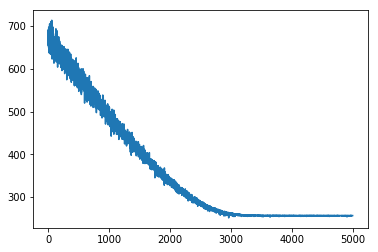

In [140]:
pyplot.plot(losses)

In [141]:
#extract the learned parameters:
alpha_q = pyro.param('alpha_q').item()
beta_q = pyro.param('beta_q').item()

#use properties of Beta Dist to find the mean and std of the latent variable:
inferred_mean = alpha_q / (alpha_q + beta_q)
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * math.sqrt(factor)
print('\nbased on the data and prior belief, the fairness ' + 
      'of the coin is {0:.3f} +- {1:.3}'.format(inferred_mean, inferred_std))


based on the data and prior belief, the fairness of the coin is 0.984 +- 0.0928


In [142]:
#for normal distribution:
print('based on data and normal prior: Mean:{0:.3}, STD:{1:.3}'.format(alpha_q, beta_q))

based on data and normal prior: Mean:0.79, STD:0.0126


Text(0,0.5,'probability distribution')

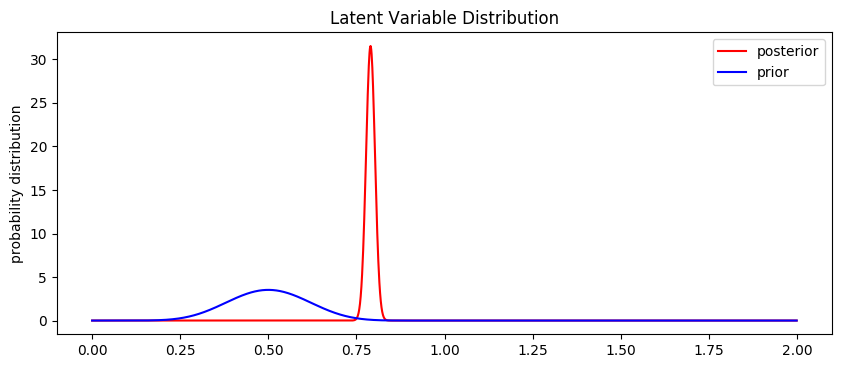

In [143]:
#plot distributions:
X = np.arange(0,2,0.001)
Prior = scipy.stats.beta.pdf(X, 10, 10)
Posterior = scipy.stats.norm.pdf(X, alpha_q, beta_q)

pyplot.figure(figsize=(10, 4), dpi=100).set_facecolor('white')
pyplot.plot(X, Posterior, 'r-', label= 'posterior')
pyplot.plot(X, Prior, 'b-', label = 'prior')
pyplot.legend(loc='best')
pyplot.title('Latent Variable Distribution')
pyplot.ylabel('probability distribution')

### Conditional Independence

In [145]:
def model(data):
    #first sample from the prior:
    f = pyro.sample('latent_fairness', dist.Beta(alpha0, beta0))
    #now loop over the samples and observe:
    for i in pyro.irange('data_loop', len(data)):
        pyro.sample('obs_{}'.format(i), dist.Bernoulli(f) ,obs=data[i])
#now let's try with iarange:
def model(data):
    #first sample from the prior:
    f = pyro.sample('latent_fairness', dist.Beta(alpha0, beta0))
    #now loop over the samples and observe:
    for i in pyro.iarange('data_loop'):
        pyro.sample('obs', dist.Bernoulli(f) ,obs=data)


### Subsampling:
$\sum_{i=1}^{N}logp(x_{i} | z) \simeq \dfrac{N}{M} \sum_{i \in I_{M}} logp(x_{i} | z) $

In [146]:
##Automatic Subsampling:
def model(data):
    #first sample from the prior:
    f = pyro.sample('latent_fairness', dist.Beta(alpha0, beta0))
    #now loop over the samples and observe:
    for i in pyro.irange('data_loop', len(data), subsample_size=5):
        pyro.sample('obs_{}'.format(i), dist.Bernoulli(f) ,obs=data[i])

#now let's try with iarange:
def model(data):
    #first sample from the prior:
    f = pyro.sample('latent_fairness', dist.Beta(alpha0, beta0), size=len(data), subsample_size=5)
    #now loop over the samples and observe:
    for i in pyro.iarange('data_loop'):
        pyro.sample('obs', dist.Bernoulli(f) ,obs=data)

##Subsampling with both global and local RVs:

$p(x,z,\beta) = p(\beta) \prod_{i=1}^{N}p(x_{i}|z_{i})p(z_{i}|\beta)$

$q(z,\beta)=q(\beta)\prod_{i=1}^{N}q(z_{i}|\beta,\lambda_{i})$


In [ ]:
def model(data):
    beta = pyro.sample("beta", ...) # sample the global RV
    for i in pyro.irange("locals", len(data)):
        z_i = pyro.sample("z_{}".format(i), ...)
        # compute the parameter used to define the observation
        # likelihood using the local random variable
        theta_i = compute_something(z_i)
        pyro.sample("obs_{}".format(i), dist.MyDist(theta_i), obs=data[i])

def guide(data):
    beta = pyro.sample("beta", ...) # sample the global RV
    for i in pyro.irange("locals", len(data), subsample_size=5):
        # sample the local RVs
        pyro.sample("z_{}".format(i), ..., lambda_i)
#subsample size is only needed for guide, as it samples from the guide, and the Pyro 
#backend makes sure that the same set of indices are used during execution of the model

Amortization:

Instead of introducing variational parameters for each sample N, we can introduce a function f in the guide:

$q(z,\beta)=q(\beta)\prod_{i=1}^{N}q(z_{i}|\beta,f(x_{i}))$

## ELBO Gradient Estimators:

$ELBO = \mathbb{E}_{q_{\phi(z)}}[logp_{\theta}(x,z)-logq_{\phi}(z)]$

$\nabla_{\phi,\theta}ELBO = \nabla_{\phi, \theta}\mathbb{E}_{q_{\phi(z)}}[logp_{\theta}(x,z)-logq_{\phi}(z)]$

$\Rightarrow \nabla_{\phi}ELBO = \nabla_{\phi}\mathbb{E}_{q_{\phi(z)}}[f_{\phi(z)}]$

Two cases:
- Reparameterizable Random Variables:

    $\mathbb{E}_{q_{\phi(z)}}[f_{\phi(z)}] = \mathbb{E}_{q(\epsilon)}[f_{\phi(g_{\phi}(\epsilon)}]$
    
    $\nabla_{\phi}\mathbb{E}_{q_{\phi(z)}}[f_{\phi(z)}] = \mathbb{E}_{q(\epsilon)}[\nabla_{\phi}f_{\phi(g_{\phi}(\epsilon)}]$
- Non-reparameterizable Random Variables:

    $\nabla_{\phi}\mathbb{E}_{q_{\phi(z)}}[f_{\phi(z)}] = \nabla_{\phi}\int q_{\phi(z)}f_{\phi(z)}dz$
    using chain rule:
    
    $\nabla_{\phi}\mathbb{E}_{q_{\phi(z)}}[f_{\phi(z)}] = \int (\nabla_{\phi}q_{\phi(z)})f_{\phi(z)} + (\nabla_{\phi}f_{\phi(z)})q_{\phi(z)}dz$

    We can't sample from $\nabla_{\phi}q_{\phi}(z)$ since it might not be a true distribution. We use the following trick: $\nabla_{\phi}q_{\phi}(z) = q_{\phi}(z)\nabla_{\phi}logq_{\phi}(z)$
            
    $\nabla_{\phi}\mathbb{E}_{q_{\phi(z)}}[f_{\phi(z)}] = \mathbb{E}_{q_{\phi(z)}}[(\nabla_{\phi}f_{\phi(z)}) + (\nabla_{\phi}logq_{\phi}(z))f_{\phi}(z)$]
    
     The above can be done using Monte Carlo estimation.
        
    
    




### Reducing Variance by Dependency Structure
use TraceGraph_ELBO loss to construct the surrogate objective that has all the unnecessary terms removed.
svi = SVI(model, guide, optimizer, TraceGraph_ELBO())

### Reducing Variance with Data-Dependent Baselines

$\mathbb{E}_{q_{\phi}(z)}[\nabla_{\phi}(logq_{\phi}(z) \times b] = 0$

Thus we can replace $logq_{\phi}(z_{i})\overline{f_{\phi}(z)}$ by $logq_{\phi}(z_{i})(\overline{f_{\phi}(z)} - b)$

Thus the mean of the estimator is not changed, but the variance could change.

sample in pyro:
z = pyro.sample("z", dist.Bernoulli(...),

                infer=dict(baseline={'use_decaying_avg_baseline': True,
                
                                     'baseline_beta': 0.95}))

###Neural Baselines:
The idea is to have a neural model to produce b. Pyro detaches the NN module parameters from being optimized in ELBO, and guide and model parameters from being optimized in the NN training. Here is the loss being optimized for NN:

Baseline loss = $(\overline{f_{\phi}(z)} - b) ^ {2})$

In [106]:
### Non parameterizable Variational Inference:
from __future__ import print_function
import os
import torch
import torch.distributions.constraints as constraints
from torch import nn
import pyro
import pyro.distributions as dist
import numpy as np
# Pyro also has a reparameterized Beta distribution so we import
# the non-reparameterized version to make our point
from pyro.distributions.testing.fakes import NonreparameterizedBeta
import pyro.optim as optim
from pyro.infer import SVI, TraceGraph_ELBO
import sys
import scipy.stats
import matplotlib.pyplot as pyplot

# enable validation (e.g. validate parameters of distributions)
pyro.enable_validation(True)

# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
max_steps = 2 if smoke_test else 150000

def param_abs_error(name, target):
    return torch.sum(torch.abs(target - pyro.param(name))).item()

In [107]:
class BaselineNN(nn.Module):
    def __init__(self, dim_input=10, dim_hidden=1):
        super(BaselineNN, self).__init__()
        self.linear = nn.Linear(dim_input, dim_hidden)
        
    def forward(self,x):
        hidden = self.linear(x)
        print(hidden)
        return hidden

In [108]:
class BernoulliBetaExample(object):
    def __init__(self, max_steps):
        # the maximum number of inference steps we do
        self.max_steps = max_steps
        # the two hyperparameters for the beta prior
        self.alpha0 = 10.0
        self.beta0 = 10.0
        # the dataset consists of six 1s and four 0s
        self.data = torch.zeros(10000)
        self.data[0:8500] = torch.ones(8500)
        self.n_data = self.data.size(0)
        # compute the alpha parameter of the exact beta posterior
        self.alpha_n = self.data.sum() + self.alpha0
        # compute the beta parameter of the exact beta posterior
        self.beta_n = - self.data.sum() + torch.tensor(self.beta0 + self.n_data)
        # initial values of the two variational parameters
        self.alpha_q_0 = 15.0
        self.beta_q_0 = 15.0
        
    def model(self, use_decaying_average_baseline):
        #Sample 'latent fairness' from the beta prior
        f = pyro.sample('latent_fairness', dist.Beta(self.alpha0, self.beta0))
        #now observe the data: Use iarange to indicate samples are conditionally independent 
        # given the fairness.
        with pyro.iarange('data_iarange'):
            pyro.sample('obs', dist.Bernoulli(f), obs = self.data)

    def guide(self, use_decaying_average_baseline):
        #Register the two variational parameters:
        alpha_q = pyro.param('alpha_q', torch.tensor(self.alpha_q_0), constraint=constraints.positive)
        beta_q = pyro.param('beta_q', torch.tensor(self.beta_q_0), constraint=constraints.positive)

        #define the baseline:
        baseline_dict = {'use_decaying_avg_baseline' : use_decaying_average_baseline, 'baseline_beta':0.90}

        #sample from the nonparameterizable beta distribution:
        pyro.sample('latent_fairness', NonreparameterizedBeta(alpha_q, beta_q), infer=dict(baseline=baseline_dict))

    def guide_nn(self, use_decaying_average_baseline):
        #Register the two variational parameters:
        alpha_q = pyro.param('alpha_q', torch.tensor(self.alpha_q_0), constraint=constraints.positive)
        beta_q = pyro.param('beta_q', torch.tensor(self.beta_q_0), constraint=constraints.positive)

        #sample from the nonparameterizable beta distribution:
        pyro.sample('latent_fairness', NonreparameterizedBeta(alpha_q, beta_q), 
                    infer=dict(baseline={'nn_baseline': BaselineNN,
                                         'nn_baseline_input': self.data}))
        
    def do_inference(self, use_decaying_average_baseline, tolerance=0.8):
        #clear the parameters:
        pyro.clear_param_store()
        #Setup the optimizer and the parameter store:
        optimizer = optim.Adam({'lr': 0.0005, 'betas':(0.93,0.999)})
        svi = SVI(self.model, self.guide, optimizer, loss=TraceGraph_ELBO())
        print('Doing inference with use_decaying_average_baseline={0}'.format(use_decaying_average_baseline))
        losses = []
        for i in range(self.max_steps):
            losses.append(svi.step(use_decaying_average_baseline))
            if i % 100 == 0:
                print(',', end='')
                sys.stdout.flush()

            #compute the distance to the parameters of the true posterior:
            alpha_error = param_abs_error('alpha_q', self.alpha_n)
            beta_error = param_abs_error('beta_q', self.beta_n)

            if alpha_error < tolerance and beta_error < tolerance:
                break
        pyplot.plot(losses)
        print("\nDid {0} steps of inference.".format(i))
        print(("Final absolute errors for the two variational parameters " +
       "were {0:.4} & {1:.4}").format(alpha_error, beta_error))

            

Doing inference with use_decaying_average_baseline=True
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

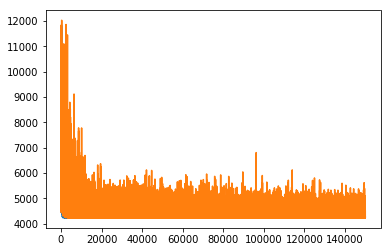

In [109]:
# do the experiment
bbe = BernoulliBetaExample(max_steps=max_steps)
bbe.do_inference(use_decaying_average_baseline=True)
bbe.do_inference(use_decaying_average_baseline=False)

43.074745178222656 9.324612617492676
tensor([ 1.,  1.,  1.,  ...,  0.,  0.,  0.])


Text(0,0.5,'probability distribution')

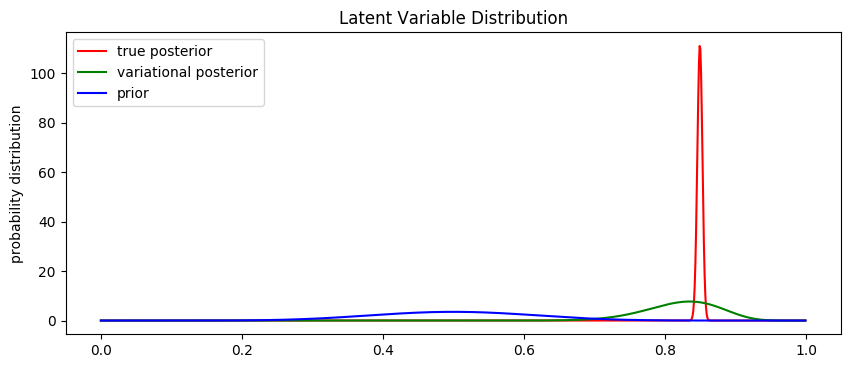

In [112]:
#plot distributions:
alpha_q = pyro.param('alpha_q').item()
beta_q = pyro.param('beta_q').item()
print(alpha_q, beta_q)
X = np.arange(0,1,0.001)
Prior = scipy.stats.beta.pdf(X, 10, 10)
Posterior = scipy.stats.beta.pdf(X, alpha_q, beta_q)
Perfect_Posterior = scipy.stats.beta.pdf(X, bbe.alpha_n, bbe.beta_n)
print(bbe.data.data)
pyplot.figure(figsize=(10, 4), dpi=100).set_facecolor('white')
pyplot.plot(X, Perfect_Posterior, 'r-', label= 'true posterior')
pyplot.plot(X, Posterior, 'g-', label= 'variational posterior')
pyplot.plot(X, Prior, 'b-', label = 'prior')
pyplot.legend(loc='best')
pyplot.title('Latent Variable Distribution')
pyplot.ylabel('probability distribution')